In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# unscaled, log-normalized counts, with conditions subsampled to the same number of cells 
# and 2000 highly variable genes calculated jointly across all perturbation conditions, including control, using scanpy28 with default parameters (Supplementary Methods)

In [3]:
import scanpy as sc
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import os
from anndata import read_h5ad
import seaborn as sns
import sys
sys.path.append("..")
from src import *
np.random.seed(42)

will use the CPU to calculate the distance matrix.


/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/graph_tool/draw/cairo_draw.py:33: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/graph_tool/draw/cairo_draw.py:33: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/graph_tool/draw/cairo_draw.py:33: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/graph_tool/all.py:39: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)


In [4]:
def prepare(adata):
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    adata = adata[:, adata.var.highly_variable]
    adata.obs[group_by] = adata.obs[group_by].astype('category')
    sc.pp.neighbors(adata, n_pcs=0)
    sc.tl.umap(adata)
    return adata

In [5]:
data_path = "/mnt/data"

In [6]:
a1 = subsample_adata(read_h5ad("/mnt/data/sciplex_A549.hdf5"), "dose_value")
a2 = subsample_adata(read_h5ad("/mnt/data/sciplex_MCF7.hdf5"), "dose_value")
a3 = subsample_adata(read_h5ad("/mnt/data/sciplex_K562.hdf5"), "dose_value")

In [7]:
group_by = "dose_value"

In [8]:
a549 = prepare(a1)
mcf7 = prepare(a2)
k562 = prepare(a3)

/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:408: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/tmp/ipykernel_4132159/2966470283.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[group_by] = adata.obs[group_by].astype('category')
/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/bionets/je30bery/singularity/gt/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:408: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/tmp/ipykernel_4132159/2966470283.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.o

In [9]:
a549.obs.columns

Index(['ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time',
       'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation',
       'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer',
       'tissue_type', 'organism', 'perturbation_type', 'ngenes',
       'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID', 'n_genes',
       'perturbation_name', 'log10(dose_value)'],
      dtype='object')

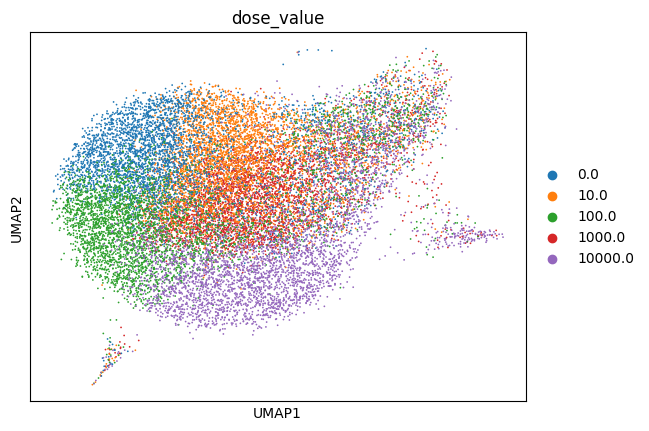

In [10]:
sc.pl.umap(a549, color="dose_value")

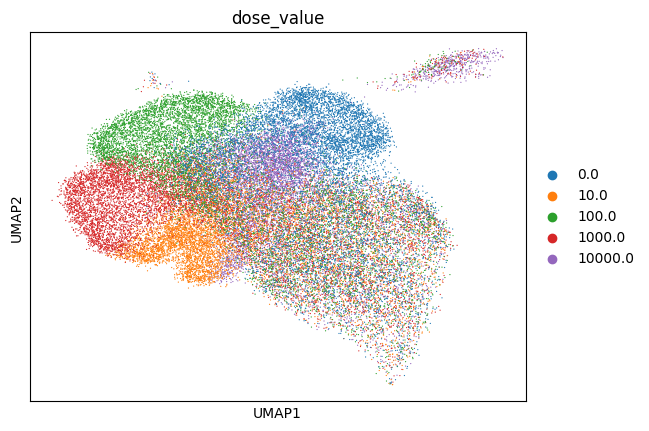

In [11]:
sc.pl.umap(mcf7, color=group_by)

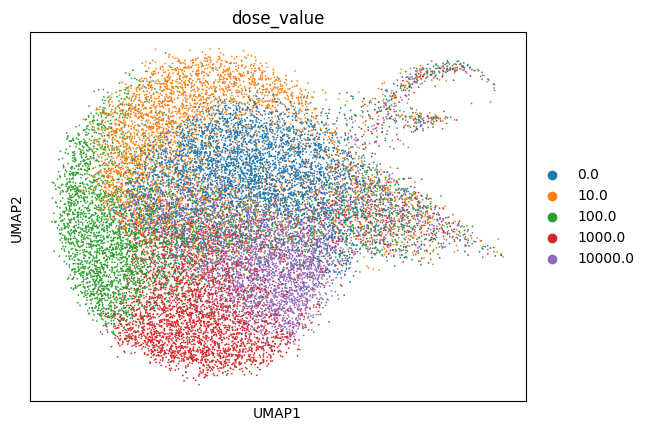

In [12]:
sc.pl.umap(k562, color=group_by)

In [13]:
dfs = pd.read_csv("../plots/sciplex_A549_combined_results_k_influence.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../plots/sciplex_A549_combined_results_k_influence.csv'

In [ ]:
dfs.rename({"Unnamed: 0": "control_group", "Unnamed: 1": "metric"}, axis=1, inplace=True)
groups = sorted(dfs["control_group"].unique())
dfs = dfs.set_index(["control_group", "metric"])

In [ ]:
adata = read_h5ad(os.path.join(data_path, "sciplex_MCF7.hdf5"))
group_by = "dose_value"
reference = 0.0
name = "/sciplex_A549"
adata = subsample_adata(adata, group_by)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

In [ ]:
colors = sns.color_palette("hls", len(groups) + 1)
pal = {group: colors[i] for i, group in enumerate(groups + [reference])}

In [ ]:
adata.obs[group_by] = adata.obs[group_by].astype('category')

In [ ]:
sc.pp.neighbors(adata, n_pcs=0)
sc.tl.umap(adata)

In [ ]:
dfs.sort_index(axis=1).sort_index(axis=0, inplace=True)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False)

k_values = sorted(dfs.columns.astype(int))

# Create a single figure with 5 subplots in one row
metrics = ['p-val', 'z-score', 'relative support', 'Percentage of reference matching edges in matching', 'Number of edges']

for i, metric in enumerate(metrics):
    x, y = (i + 1) // 3, (i + 1) % 3

    
    for group in groups:
        df = dfs.loc[group]
        df = df[np.array(sorted(df.columns.astype(int))).astype(str)]
        axes[x, y].plot(df.columns.astype(float), df.loc[metric], 'o-', label=group, color=pal[group], alpha=0.7)
    if metric in ['p-val', 'Number of edges']:
        axes[x, y].set_yscale('log')
    axes[x, y].set_title(metric)
    axes[x, y].set_xlabel('k')
    #axes[x, y].legend()

    #axes[x, y].legend(
    #    loc='best',
     #   labels=groups,
    #    title=group_by
    #)

    #axes[x, y].set_xscale("log")
    axes[x, y].set_xticks(k_values) 

sc.pl.umap(adata, color=group_by, palette=pal, ax=axes[0,0], legend_loc='upper right')
plt.tight_layout()
plt.show()
#plt.savefig("k_influence_sciplex_A549.pdf")